# Projet P6 : Classifiez automatiquement des biens de consommation

## Contexte

<b> MISSION 1 : </b>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 
- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
 
Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ? 

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
 
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

<b> MISSION 2 : </b>

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle. 

De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fin

 

Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’API dis ponib
https://developer.edamam.com/food-database-apiei ? 

 

Pourrais-tu ensuite nous proposer un script ou notebook Python permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Etapes du projet :

Démontrer la faisabilité de regrouper automatiquement des produits de même catégorie.

- <b> Etape préliminaire : </b> Importation des données ( --> NoteBook1 : Traitement des textes )
- <b> Etape 1 : </b> Text cleaning et feature engineering ( --> NoteBook1 : Traitement des textes ) 
- <b> Etape 2 : </b> Catégorisation des descriptions ( --> NoteBook 2 et 3 : Méthodes bag of words et Word_embedding )
- <b> Etape 3 : </b> Pré-traitement et classification d'images (SIFT et CNN) ( --> NoteBook4 : Traitement des images )
- <b> Etape 4 : </b> Classification supervisée des images ( --> NoteBook5 : Classification des images )
- <b> Etape 5 : </b> Collecte de produits via API ( --> NoteBook6 : Collecte produits API )

Livrables : 
- Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité)
- Un notebook de classification supervisée des images
- Un script Python (notebook ou fichier .py) de test de l’API et le fichier au format “csv” contenant les produits extraits

### Environnement de travail et librairies

In [1]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\envs\Formation_P6_IMAGES\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


In [40]:
# Builtin
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'

os.environ["OMP_NUM_THREADS"] = "5"
# Importer les autres bibliothèques après avoir défini la variable d'environnement

from os import listdir
import time

# Data
import numpy as np
import pandas as pd

# Reduction de dimensions
from sklearn import decomposition
from sklearn import manifold

# Encodage
from sklearn import preprocessing

# Viz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.image import imread
import seaborn as sns

# CNN
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

sns.set_palette('Set3')

# Clustering
from sklearn import cluster, metrics


## Etape 3 : Pré-traitement et classification d'images (étude de faisabilité)

ETAPE 3
    
    1. Préparation du DataSet
        - Importation des données images et catégories
        - Extraction des catégories
        - Liste des images
   
    2. Pré-traitement des images et extraction des features via SIFT
       - création des descripteurs SIFT
       - création des features des images
       - Réduction de dimension et classification des images

    3. Classification automatique des images avec CNN
       - création du modèle pré-entrainé
       - création des features des images
       - Réduction de dimension et classification des images

### 1. Préparation du DataSet

#### -- Importation des images --

In [8]:
path = "C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\Flipkart\\Images\\"
# list_photos = [file for file in listdir(path)]
# print(len(list_photos))

In [9]:
# print(list_photos[:10])

#### -- Importation des articles --

In [11]:
articles_images = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv")

In [12]:
# Selection des variables qui vont nous intéresser
vars = ['product_category_tree','image']
articles_images = articles_images[vars]
articles_images.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


#### -- Splitter la variable 'product_category_tree' en sous-catégories --

In [19]:
# Retier les signes [""] dans le texte de la variable
articles_images['product_category_tree'] = articles_images['product_category_tree'].str.slice(2, -2)
# Séparer les catégories en plusieurs colonnes
categories_split = articles_images['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les colonnes pour une meilleure clarté
categories_split.columns = ['category_product', 'category_2', 'category_3','category_4', 'category_5', 'category_6','category_7']

# Joindre la colonne category_product avec le DataFrame original
articles_images = articles_images.join(categories_split['category_product'])
articles_images = articles_images.drop(columns='product_category_tree') # On supprime la variable d'origine
articles_images.head()

,image,category_product
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [21]:
# Vérification sur une image
filtered_rows = articles_images[articles_images['image'] == '142994b421c052a6193052c6c8c3d076.jpg']
# Afficher les lignes filtrées
print(filtered_rows)

                                    image          category_product
692  142994b421c052a6193052c6c8c3d076.jpg  Beauty and Personal Care


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- nous avons 1050 images de produits uniques dans l'échantillon de données avec leur catégorie
- il y a 7 catégories de produits
    
</div>

#### -- Encodage de la catégorie de produit --

In [25]:
# Encodage de la catégorie de produit
le = preprocessing.LabelEncoder()
articles_images["category_code"] = le.fit_transform(articles_images["category_product"])
print(articles_images["category_code"])

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: category_code, Length: 1050, dtype: int32


#### -- Exemples d'images par label --

Home Furnishing


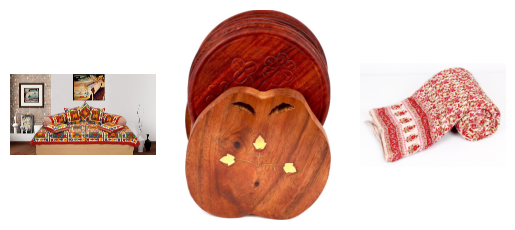

Baby Care


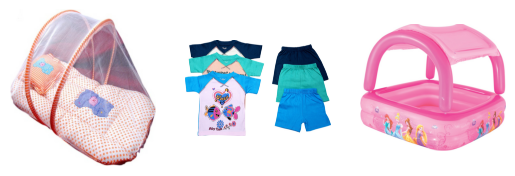

Watches


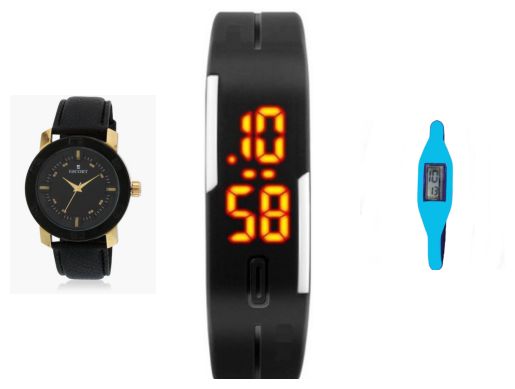

Home Decor & Festive Needs


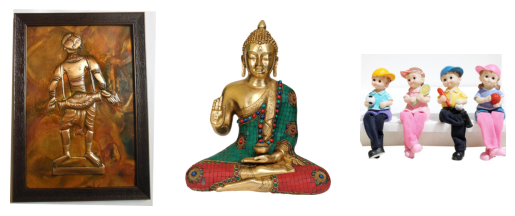

Kitchen & Dining


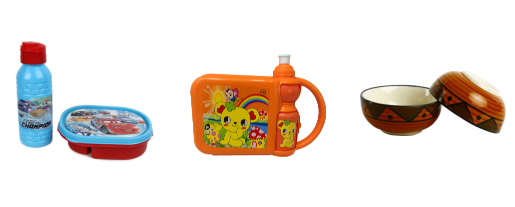

Beauty and Personal Care


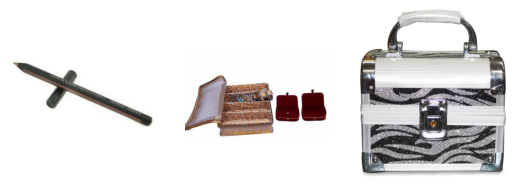

Computers


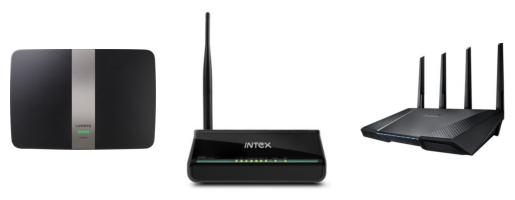

In [28]:
# Liste des labels uniques
list_labels = articles_images["category_product"].unique()

# Fonction pour obtenir les noms d'image pour une catégorie donnée
def list_fct(name):
    list_image_name = articles_images.loc[articles_images["category_product"] == name, "image"].tolist()
    return list_image_name

# Boucle pour chaque catégorie de produit
for name in list_labels:
    print(name)
    list_images = list_fct(name)

    # Affichage des images
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_images[i + 10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()

### 2. Pré-traitement des images via SIFT

#### -- Détermination et affichage des descripteurs SIFT --

Les descripteurs SIFT (Scale-Invariant Feature Transform) sont utilisés en vision par ordinateur et traitement d'images pour détecter et décrire des points d'intérêt dans une image.

SIFT utilise une technique appelée "Laplacian of Gaussian" pour détecter des points d'intérêt à différentes échelles de l'image. Cette étape permet de trouver des points qui sont significatifs et stables sous des variations d'échelle.

Le descripteur final est une représentation compacte (typiquement un vecteur de 128 dimensions) des caractéristiques locales autour du point d'intérêt, capturant les gradients de l'intensité de l'image dans plusieurs directions et à plusieurs échelles.

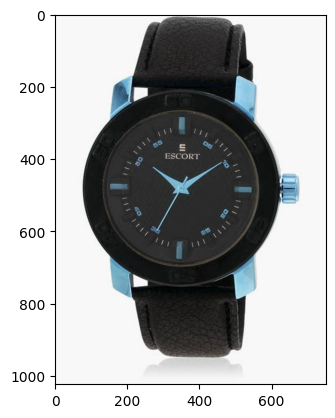

In [41]:
import cv2
plt.imshow(cv2.imread(path+articles_images['image'][15]))

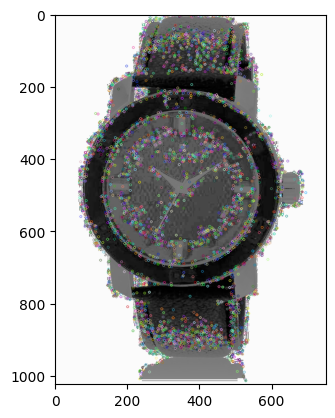

Descripteurs :  (4292, 128)
Catégorie :  Watches

[[  0.  36.  70. ...   1.  17.  17.]
 [ 67.   7.   3. ...   0.   0.   7.]
 [ 46.  81.  49. ...   0.   0.   2.]
 ...
 [  0.   0.   0. ...   6.  18. 123.]
 [ 30.  30.  11. ...   0.   0.   2.]
 [ 47. 138. 132. ...   0.   0.   0.]]


In [43]:
sift = cv2.SIFT_create() # nfeatures=150
image = cv2.imread(path+articles_images['image'][15],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print("Catégorie : ", articles_images['category_product'][15])
print()
print(des)

# Le nb de descripteurs varie énormément selon les images, 700, 1700, 4600, 13000...
# Chaque descripteur est un vecteur de longueur 128

#### -- Créations des descripteurs de chaque image --
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [74]:
sift_keypoints = [] # Liste pour stocker les descripteurs SIFT pour chaque image
temps1 = time.time() # Enregistrer le temps de début pour mesurer la durée du traitement

# Initialiser l'algorithme SIFT pour détecter jusqu'à 500 points clés --> à modifier si besoin
sift = cv2.SIFT_create(500)

# Boucle sur toutes les images dans la liste des photos
for image_num in range(len(articles_images['image'])):
    if image_num%100 == 0 : print(image_num)  # Imprimer le numéro de l'image tous les 100 itérations
    image_path = path + articles_images['image'][image_num]
    image = cv2.imread(image_path, 0) # Lire l'image et la convertir en niveaux de gris
    res = cv2.equalizeHist(image) # Égaliser l'histogramme de l'image pour améliorer le contraste
    kp, des = sift.detectAndCompute(res, None) # Détecter les points clés et calculer les descripteurs SIFT

    sift_keypoints.append(des)

duration1=time.time()-temps1
print("temps de traitement création des descripteurs : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de traitement création des descripteurs :           281.81 secondes


In [47]:
# Initialiser une liste vide pour stocker les tableaux concaténés
sift_keypoints_by_img = []

# Ajouter chaque tableau à la liste
for kp in sift_keypoints:
    sift_keypoints_by_img.append(kp)

# Concaténer les tableaux le long de l'axe 0
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

# Vérifier la forme et le type de données
print(sift_keypoints_all.shape)
print(sift_keypoints_all.dtype)

(989655, 128)
float32


In [49]:
len(sift_keypoints_by_img) # 1050 images

1050

In [51]:
sift_keypoints_by_img[1].shape # (500, 128), certaines images sont inférieures à 500

(1000, 128)

descripteur de l'image 1 : [[12.  9. 26. ...  7. 61.  4.]
 [42.  3.  0. ...  5.  7.  1.]
 [38. 14.  1. ...  0.  0.  0.]
 ...
 [62. 16.  1. ... 79. 33. 15.]
 [60. 22.  3. ...  1.  0. 47.]
 [ 0.  2. 12. ...  4.  1.  4.]]
Descripteurs :  (1001, 128)
Catégorie :  Watches


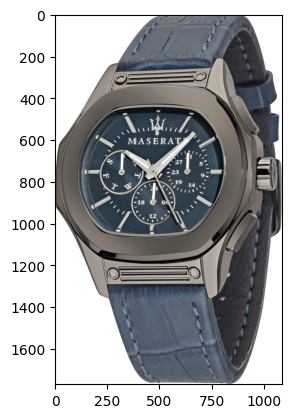

In [53]:
# Vérification sur une image
print("descripteur de l'image 1 :", sift_keypoints_by_img[5])
print("Descripteurs : ", sift_keypoints_by_img[5].shape)
filename = path + articles_images['image'][5]
image = imread(filename)
plt.imshow(image)
print("Catégorie : ", articles_images['category_product'][5])

#### -- Création du dictionnaire de visual words --
* Pour créer le "dictionnaire" de visual words, application d'un algorithme de clustering aux descripteurs de features construits. Les visual words correspondent alors aux centres des clusters trouvés.
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [56]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0)) # 719 clusters
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, batch_size=3584)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  995
Création de 995 clusters de descripteurs ...
temps de traitement kmeans :             5.83 secondes


#### -- Création des features des images --
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster
Décrire les images en fonction de ces visual words (=centres des clusters). Pour chaque image, on crée un histogramme qui indique la fréquence d'apparition de chaque visual word dans l'image.

In [60]:
# Creation of histograms (= features)
temps1=time.time() # Début du chronométrage pour mesurer la durée de création des histogrammes

# Fonction pour construire un histogramme à partir des descripteurs SIFT
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des) # Prévoit les centres de cluster pour chaque descripteur
    hist = np.zeros(len(kmeans.cluster_centers_)) # Initialise l'histogramme avec des zéros, la longueur est égale au nombre de centres de cluster
    nb_des=len(des) # Nombre de descripteurs pour cette image
    if nb_des==0 : print("problème histogramme image  : ", image_num) # Vérifie si le nombre de descripteurs est zéro et affiche un message d'erreur si c'est le cas
    for i in res: # Remplit l'histogramme en incrémentant les bins correspondant aux prédictions des clusters
        hist[i] += 1.0/nb_des
    return hist


# Liste pour stocker les vecteurs d'histogrammes de toutes les images
hist_vectors=[]

# Boucle sur chaque image et ses descripteurs SIFT
for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)   # Affiche une progression toutes les 100 images
    hist = build_histogram(kmeans, image_desc, i) # Calcule l'histogramme pour l'image actuelle
    hist_vectors.append(hist) # Ajoute l'histogramme (vecteur de caractéristiques) à la liste des histogrammes

im_features = np.asarray(hist_vectors) # Convertit la liste des histogrammes en un tableau NumPy

duration1=time.time()-temps1 # Calcule la durée totale pour la création des histogrammes
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             3.04 secondes


#### -- Réduction de dimension PCA --
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [63]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 995)
Dimensions dataset après réduction PCA :  (1050, 577)


#### -- Fonctions de réduction de dimension tsne et clustering --

In [50]:
### Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
l_cat = list(set(articles_images["category_product"]))
print("catégories : ", l_cat)
# y_cat_num = [(1-l_cat.index(articles_images.iloc[i]['category_product'])) for i in range(len(articles_images))]
y_cat_num = articles_images["category_code"]

def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, max_iter=2000, init='random', random_state=42)
    # tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=10, random_state=42)
    # cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set2')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des images par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set2')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des images par clusters')
    
    plt.show()
    print("ARI : ", ARI)

catégories :  ['Home Furnishing', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining', 'Computers', 'Baby Care', 'Watches']


#### -- Réduction de dimension T-SNE --
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [69]:
ARI, X_tsne, labels = ARI_fct(feat_pca)

ARI :  0.0655 time :  8.0


#### -- Affichage T-SNE selon catégories d'images --

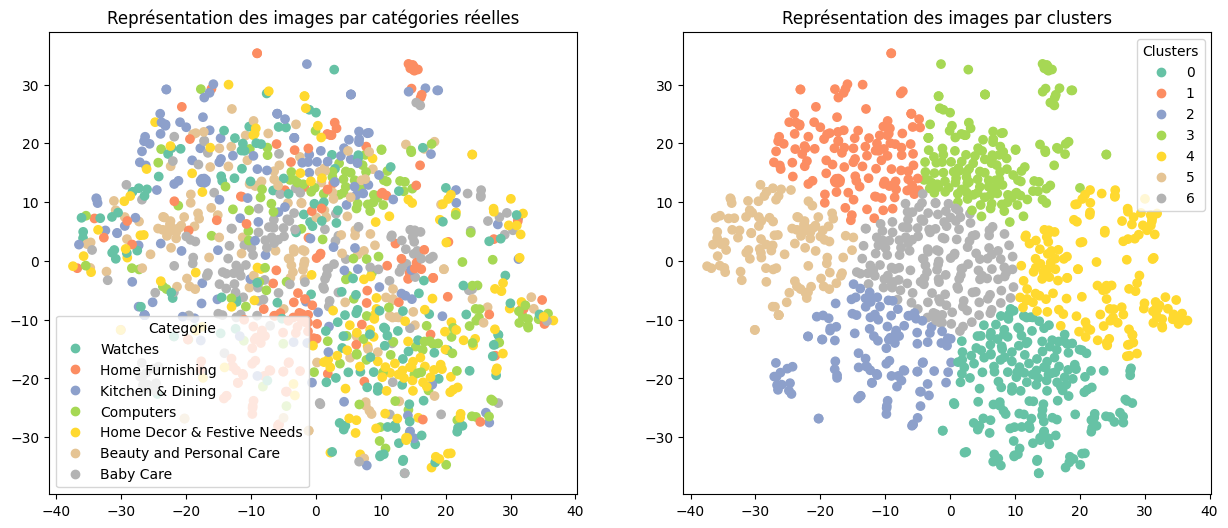

ARI :  0.0655


In [71]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> RESULTATS avec SIFT : </b> 
    
- La catégorisation des images sur la base des descripteurs SIFT n'est pas concluante
- Le clustering de dissocie pas les catégories avec ces informations
- Le ARI est très faible = 0.05, les catégories ne sont pas visibles sur le graphique en 2D
    
</div>

### 3. Etude de faisabilité de classification des images avec CNN

#### -- Création du modèle pré-entrainé --

VGG16 est un modèle de réseau de neurones convolutionnel (CNN) bien connu pour la classification d'images.

In [33]:
# Chargement du modèle VGG16 pré-entraîné sur la base de données ImageNet
base_model = VGG16()
# Création d'un nouveau modèle en utilisant l'API Keras Model
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
# inputs=base_model.inputs : Le nouveau modèle utilise les mêmes entrées que le modèle VGG16 original.
# outputs=base_model.layers[-2].output : Le nouveau modèle utilise la sortie de l'avant dernière couche du modèle VGG16 comme sortie. 
# L'avant dernière couche est généralement une couche de convolution ou une couche dense juste avant la couche de classification finale.

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


#### -- Création des features des images --

In [36]:
articles_images["image_path"] = path+articles_images['image']
articles_images.head()

,image,category_product,category_code,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,C:\Users\druar\OneDrive\Documents\01_Formation...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,C:\Users\druar\OneDrive\Documents\01_Formation...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,C:\Users\druar\OneDrive\Documents\01_Formation...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,C:\Users\druar\OneDrive\Documents\01_Formation...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,C:\Users\druar\OneDrive\Documents\01_Formation...


In [42]:
# Charger les images, les redimensionner, les prétraiter, puis utiliser un modèle VGG16 pré-entraîné pour extraire les caractéristiques de haut niveau.
images_features = []
temps1=time.time()
i=0 
for image_file in articles_images["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224)) # Charger l'image à partir du fichier et la redimensionner à 224x224 pixels
    image = img_to_array(image)  # Convertir l'image en tableau numpy
    image = np.expand_dims(image, axis=0) # Ajouter une dimension supplémentaire pour correspondre au format attendu par le modèle (lot de taille 1)
    image = preprocess_input(image) # Prétraiter l'image (normalisation spécifique à VGG16)
    images_features.append(model.predict(image, verbose=0)[0]) # Prédire les caractéristiques de l'image en utilisant le modèle pré-entraîné
    # Le paramètre verbose=0 désactive l'affichage de la progression de la prédiction

images_features = np.asarray(images_features) # Convertir la liste de caractéristiques en un tableau numpy
images_features.shape # Afficher la forme du tableau numpy contenant les caractéristiques des images

duration1=time.time()-temps1
print("temps de traitement : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600


C:\Users\druar\anaconda3\envs\Formation_P6_IMAGES\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
temps de traitement :           205.43 secondes


#### -- Réduction de dimension PCA --

In [45]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


#### -- Réduction de dimension T-SNE --

In [52]:
import time

ARI, X_tsne, labels = ARI_fct(feat_pca)

ARI :  0.4517 time :  7.0


#### -- Affichage T-SNE selon catégories d'images --

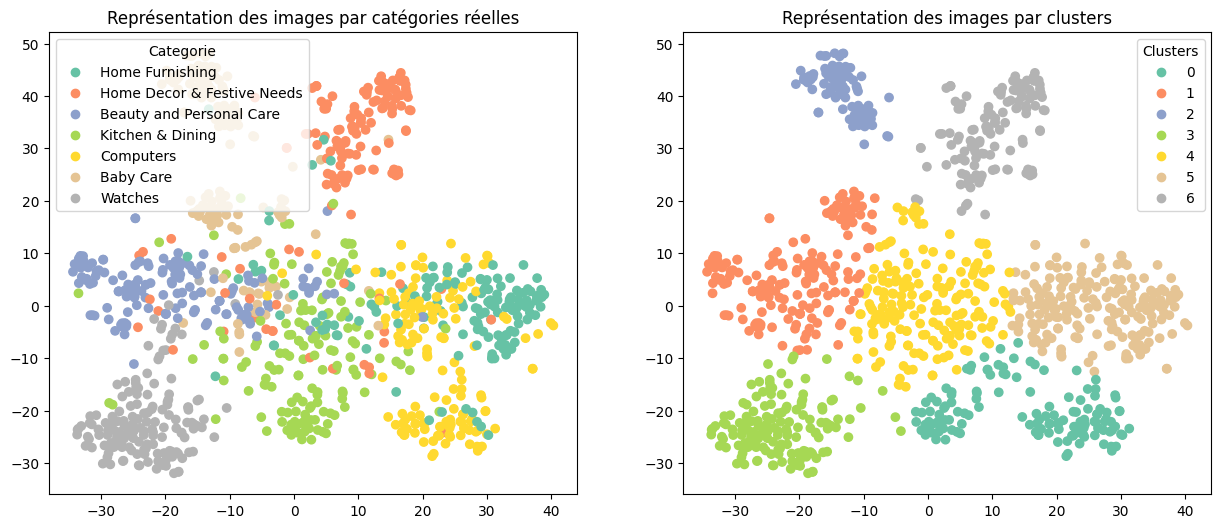

ARI :  0.4517


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

A RETENIR :
* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

#### -- Analyse par classes --

In [60]:
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = articles_images["category_product"]
df_tsne["cluster"] = labels
print(df_tsne.shape)

(1050, 4)


In [62]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    136
1    177
2     80
3    145
4    188
5    197
6    127
Name: class, dtype: int64

In [64]:
conf_mat = metrics.confusion_matrix(articles_images["category_code"], labels)
print(conf_mat)

[[  9   1   1   1  26 109   3]
 [  6   9   1   0  12   5 117]
 [  0 113   0   1  34   1   1]
 [ 54   6   0   8  78   3   1]
 [ 67   0   0   0   5  78   0]
 [  0  35  78   0  31   1   5]
 [  0  13   0 135   2   0   0]]


In [66]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    # corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(articles_images["category_code"], labels)
conf_mat = metrics.confusion_matrix(articles_images["category_code"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(articles_images["category_code"], cls_labels_transform))

Correspondance des clusters :  [4 2 5 6 3 0 1]
[[109   3   1  26   9   1   1]
 [  5 117   9  12   6   1   0]
 [  1   1 113  34   0   0   1]
 [  3   1   6  78  54   0   8]
 [ 78   0   0   5  67   0   0]
 [  1   5  35  31   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.55      0.73      0.63       150
           1       0.92      0.78      0.84       150
           2       0.64      0.75      0.69       150
           3       0.41      0.52      0.46       150
           4       0.49      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



In [68]:
label_corresp = ['Baby Care','Beauty and Personal Care', 'Computers','Home Decor & Festive Needs' , 'Home Furnishing',  'Kitchen & Dining', 'Watches']

<Axes: >

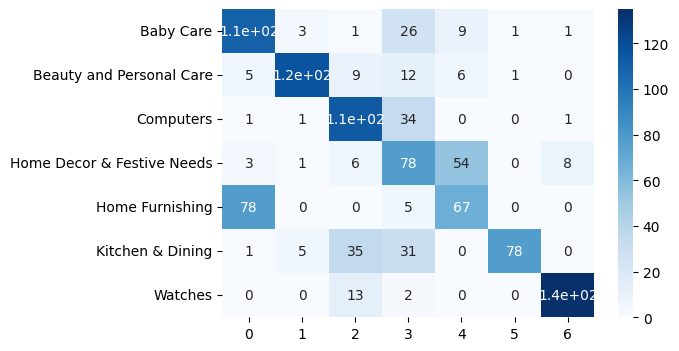

In [70]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_corresp],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

<div class="alert alert-block alert-info">
    <b> RESULTATS avec CNN : </b> 
    
- On voit visuellement et avec un ARI de 0.45 que la classification est possible en utilisant un Réseau de neurones pré-entrainé sur des images
- Les classes les moins bien prédites sont les classes : "Home Decor & Festive Needs" - "Kitchen & Dining" - "Home Furnishing" --> la classification supervisée sera bien plus performante
    
</div>